# Mode Solver

## Theory

The total potential energy $V$ is
$$
V(x,y,z) = \sum_{n=1}^N q  \Phi_\text{dc}(z_n) + \sum_{n>m}^{N} \frac{q^2}{4 \pi \epsilon_{0}} \frac{1}{\left|z_{n}-z_{m}\right|}
$$
where $z_n$ is the position of n-th ion. And we stipulate that if $i<j$, $z_i<z_j$.

Introducing a dimensionless parameter $\zeta = z/r_0, \zeta \in [-1,1]$. The potental energy on the $z$ axis is
$$
V(x,y,z) = \sum_{n=1}^N q  \Phi_\text{dc}(\zeta_n) + \sum_{n>m}^{N} \frac{q^2}{4 \pi \epsilon_{0} r_0} \frac{1}{\left|\zeta_{n}-\zeta_{m}\right|}
$$
To find equilibrium position $\zeta_n^0$, one can take the derivative of $V(\zeta_n)$, then obtain $N$ equations
$$
\frac{\partial V}{\partial \zeta_n} = q \frac{\partial \Phi_\text{dc}}{\partial \zeta_n} - \sum_{m=1}^{n-1} \frac{q^2}{4 \pi \epsilon_{0} r_0} \frac{1}{\left(\zeta_n-\zeta_m\right)^2} + \sum_{m=n+1}^{N} \frac{q^2}{4 \pi \epsilon_{0} r_0} \frac{1}{\left(\zeta_n-\zeta_m\right)^2} = 0 ,\, (n=1,2,\cdots,N)
$$
we will use `scipy.optimize.root` method to solve them.

The Lagrangian of the system is:
$$
L = T-V = \sum_{n=1}^{N} \frac{1}{2} M \left(\dot{q}_{n}\right)^2-\sum_{n, m=1}^{N} \frac{1}{2} \left[\frac{\partial^{2} V}{\partial z_n \partial z_m}\right]_0 q_n q_m
$$
where the coefficient matrix is
$$
\frac{\partial^{2} V}{\partial z_n \partial z_m} = \frac{1}{r_0^2} \frac{\partial^{2} V}{\partial \zeta_n \partial \zeta_m} = \frac{1}{r_0^2}
\begin{cases}
\frac{\partial^2 V}{\partial \zeta_n^2} ,\, &n=m \\
-\frac{2 q^2}{4 \pi \epsilon_{0} r_0} \frac{1}{\left|\zeta_n - \zeta_m\right|^3} ,\, &n \neq m
\end{cases}
$$
and
$$
\frac{\partial^2 V}{\partial \zeta_n^2} = q \frac{\partial^2 \Phi_\text{dc}}{\partial \zeta_n^2} +
 \sum_{m=1}^{n-1} \frac{2 q^2}{4 \pi \epsilon_{0} r_0} \frac{1}{\left(\zeta_n-\zeta_m\right)^3} - \sum_{m=n+1}^{N} \frac{2 q^2}{4 \pi \epsilon_{0} r_0} \frac{1}{\left(\zeta_n-\zeta_m\right)^3} ,\, (n=1,2,\cdots,N)
$$
The angular freqencies are square roots of eigenvalues of the matrix divided by $m_{\mathrm{Ca}}$.

## Main Program

In [28]:
from scipy.optimize import fsolve,minimize_scalar
from scipy.interpolate import UnivariateSpline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from globalvar import *
from freqsol import *
from load import *

In [29]:
DCset = {'DC1':10, 'DC2':-0.5, 'DC3':-0.5, 'DC4':10} # set DC voltage here
DataLabel = 'x,y,z,esbeV' # set your data labels here

Load data generated by COMSOL, and compute the electrical potential based on DC voltage settings

In [30]:
[x,y,z,esbeVs] = load(DataLabel)
esbeV = np.zeros_like(z)
for DCi in DCset:
    esbeV = esbeV + esbeVs[DCi]*DCset[DCi]

## Mode Solver

Interpolate and get the potential function $V_\text{spl}(\zeta)$

In [31]:
zeta = z/(r0*1e6)
zetagrid = np.linspace(-0.95,0.95,128)
smoothfactor = 1e-6

Vspl = UnivariateSpline(zeta,esbeV,k=5,s=smoothfactor) # spl.get_residual() <= s
dVspl = Vspl.derivative(1)
ddVspl = Vspl.derivative(2)

Define a appropriate initial postion of two ions, then use the solver to find the equilibrium postion and eigenmodes

inipos: [-0.00664268  0.00664268]
w0/2pi = 1.082MHz
w1/2pi = 1.874MHz
eqpos: [-0.00625286  0.00703231]
sep = 5.31um


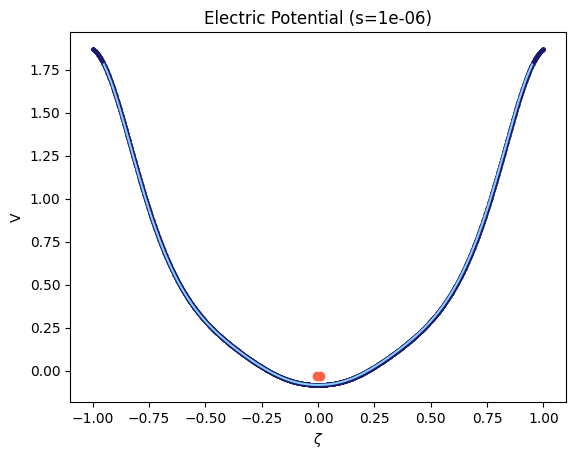

In [32]:
inipos = SymEqposition(dVspl,2)
print('inipos:',inipos)
zeta0 = Eqposition(dVspl,ddVspl,inipos)
# zeta0 = SymEqposition(dVspl,2)
for i in range(2):
    print('w{0}/2pi = {1:.3f}MHz'.format(i,AxialMode(ddVspl,zeta0)[i]/1e6))
print('eqpos:',zeta0)
sep = (zeta0[1]-zeta0[0])*400
print('sep = {:.2f}um'.format(sep))

plt.figure()
plt.scatter(zeta,esbeV,s=4,color="midnightblue")
plt.plot(zetagrid,Vspl(zetagrid),color="lightskyblue")
plt.scatter(zeta0,Vspl(zeta0)+0.05,color="tomato")
plt.title('Electric Potential (s={:.0e})'.format(smoothfactor))
plt.xlabel(r'$\zeta$')
plt.ylabel('V')
plt.show()

Find the dependence of eigenmodes and equilibrium position with respect to DC2 when fix DC1 and DC3 to 10V

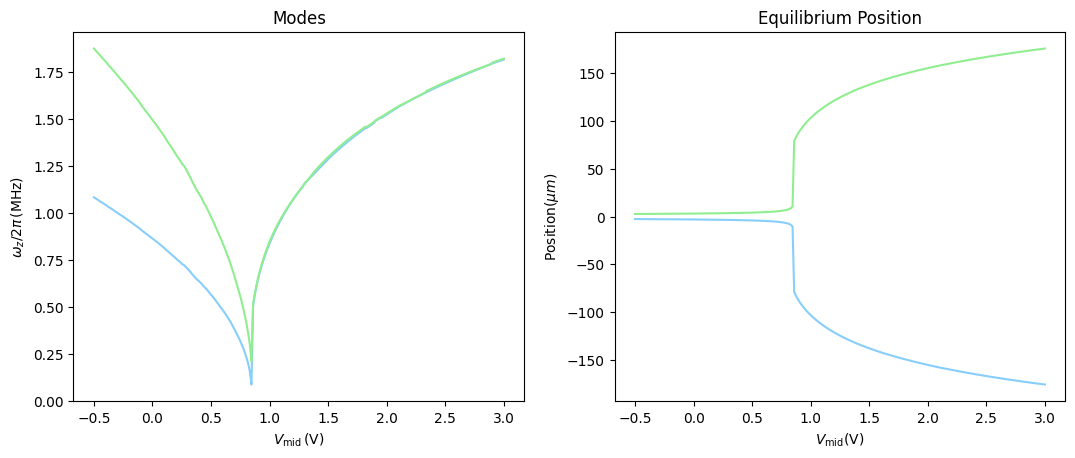

In [33]:
DCmidset = np.linspace(-0.5,3,256)
eqposL = np.empty_like(DCmidset)
eqposR = np.empty_like(DCmidset)
w0 = np.empty_like(DCmidset)
w1 = np.empty_like(DCmidset)

for i in range(256):
    esbeV = np.zeros_like(z)
    DCset['DC2'] = DCmidset[i]
    DCset['DC3'] = DCmidset[i]
    for key in DCset:
        esbeV = esbeV + DCset[key] * esbeVs[key]
    Vspl = UnivariateSpline(zeta,esbeV,k=5,s=smoothfactor)
    dVspl = Vspl.derivative(1)
    ddVspl = Vspl.derivative(2)

    # inipos = SymEqposition(dVspl)
    # zeta0 = Eqposition(dVspl,ddVspl,inipos)
    zeta0 = SymEqposition(dVspl)
    
    [eqposL[i],eqposR[i]] = [zeta0[0],zeta0[1]]
    [w0[i],w1[i]] = AxialMode(ddVspl,zeta0)/1e6
    
plt.figure(figsize=[12.8,4.8])
plt.subplot(1,2,1)
plt.plot(DCmidset,w0,color='lightskyblue', label=r'$\omega_0(ctrlV)$')
plt.plot(DCmidset,w1,color='lightgreen', label=r'$\omega_1(ctrlV)$')
plt.title('Modes')
plt.xlabel(r'$V_\mathrm{mid}\,(\mathrm{V})$')
plt.ylabel(r'$\omega_z/2\pi\,(\mathrm{MHz})$')

plt.subplot(1,2,2)
plt.plot(DCmidset,eqposL*r0*1e6, color='lightskyblue', label='eqposL(ctrlV)')
plt.plot(DCmidset,eqposR*r0*1e6, color='lightgreen', label='eqposR(ctrlV)')
plt.title('Equilibrium Position')
plt.xlabel(r'$V_\mathrm{mid}(\mathrm{V})$')
plt.ylabel(r'Position($\mu m$)')
plt.show()

## Multi-ions

In [34]:
ionNumber = 4
DCset = {'DC1':10, 'DC2':0.654, 'DC3':0.654, 'DC4':10} # set DC voltage here

esbeV = np.zeros_like(z)
for DCi in DCset:
    esbeV = esbeV + esbeVs[DCi]*DCset[DCi]

Define a appropriate initial postion of multi-ions.

In [35]:
def MultiTrialEqpos(ionNumber):
    sep = 0.2
    inipos = np.linspace(-(ionNumber-1)/2*sep,(ionNumber-1)/2*sep,ionNumber)
    return inipos

Evaluate the equilibrium postion and modes

w0 = 0.428MHz
w1 = 0.742MHz
w2 = 1.036MHz
w3 = 1.316MHz
eqpos: [-0.02578135 -0.00661481  0.01105346  0.03020129]


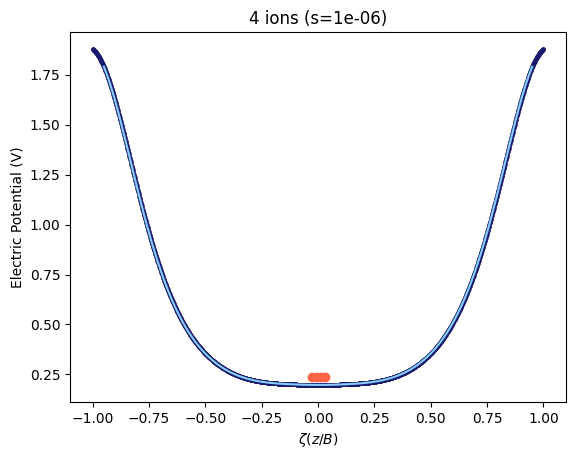

In [36]:
Vspl = UnivariateSpline(zeta,esbeV,k=5,s=smoothfactor) # spl.get_residual() <= s
dVspl = Vspl.derivative(1)
ddVspl = Vspl.derivative(2)

inipos = MultiTrialEqpos(ionNumber)
zeta0 = Eqposition(dVspl,ddVspl,inipos,ionNumber)
for i in range(ionNumber):
    print('w{0} = {1:.3f}MHz'.format(i,AxialMode(ddVspl,zeta0,ionNumber)[i]/1e6))
print('eqpos:',zeta0)

plt.figure()
plt.scatter(zeta,esbeV,s=4,color="midnightblue")
plt.plot(zetagrid,Vspl(zetagrid),color="lightskyblue")
plt.scatter(zeta0,Vspl(zeta0)+0.04,color="tomato")
plt.title('{} ions (s={:.0e})'.format(ionNumber,smoothfactor))
plt.xlabel(r'$\zeta(z/B)$')
plt.ylabel('Electric Potential (V)')
plt.show()

## Superposition

In [37]:
import ipywidgets

In [38]:
def esbeV_plot(DC1=10,DC2=0.6,DC3=0.6,DC4=10):
    DCset = {'DC1':DC1, 'DC2':DC2, 'DC3':DC3, 'DC4':DC4}
    esbeV = np.zeros_like(z)
    for DCi in DCset:
        esbeV = esbeV + esbeVs[DCi]*DCset[DCi]
    # plt.subplot(2,3,1)
    # plt.plot(z,esbeVs['DC1'],label='DC1')
    # plt.legend()
    
    # plt.subplot(2,3,2)
    # plt.plot(z,esbeVs['DC2'],label='DC2')
    # plt.legend()

    # plt.subplot(2,3,3)
    # plt.plot(z,esbeVs['DC3'],label='DC3')
    # plt.legend()

    # plt.subplot(2,3,4)
    # plt.plot(z,esbeVs['DC4'],label='DC3')
    # plt.legend()
    
    # plt.subplot(2,3,5)
    plt.plot(z,esbeV,label='esbeV')
    plt.legend()

In [39]:
ipywidgets.interact(esbeV_plot,DC1=(-10,10,0.1),DC2=(-10,10,0.1),DC3=(-10,10,0.1),DC4=(-10,10,0.1))

interactive(children=(FloatSlider(value=10.0, description='DC1', max=10.0, min=-10.0), FloatSlider(value=0.6, …

<function __main__.esbeV_plot(DC1=10, DC2=0.6, DC3=0.6, DC4=10)>